In [1]:
# imports
import time
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-01-29 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-02-01 00:00:00
train_valid_split_datetime: 2018-01-29 00:00:00


In [2]:
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
print('manhattan_location_ids:', manhattan_location_ids.shape)
manhattan_location_ids

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,)


array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 103, 104, 105, 107, 113, 114, 116, 120,
       125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153,
       158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224,
       229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246,
       249, 261, 262, 263])

In [3]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [89]:
train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)
last_5min_id = get_5min_id(last_datetime)
last_15min_id = get_15min_id(last_datetime)
last_30min_id = get_30min_id(last_datetime)
print('last_5min_id:', last_5min_id)
print('last_15min_id:', last_15min_id)
print('last_30min_id:', last_30min_id)

train_valid_split_5min_id: 8064.0
train_valid_split_15min_id: 2688.0
train_valid_split_30min_id: 1344.0
last_5min_id: 8928.0
last_15min_id: 2976.0
last_30min_id: 1488.0


In [6]:
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] > 0]
    print('filter trip_distance:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']*3600
    print('trip_speed:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] > 0]
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] <= 200]
    print('filter trip_speed:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [7]:
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
    sample_manhattan = filter_abnormal_data(sample)
else:
    for m in range(1, 2):  # (1, 7)
        start = time.time()
        sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
        print('read_csv 2018-0'+str(m)+':', time.time()-start)
        sample_1 = filter_abnormal_data(sample_1)
        print('filter_abnormal_data:', time.time()-start)
        if m == 1:
            sample_manhattan = sample_1
        else:
            sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        print('concat:', time.time()-start)
print('sample_manhattan:', sample_manhattan.shape)

start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

read_csv 2018-01: 22.178088188171387
filter PULocationID: (7965703, 17) 2.0981991291046143
tpep_pickup_datetime: 4.150105714797974
tpep_dropoff_datetime: 6.1768834590911865
filter trip_distance: (7935134, 17) 6.8687684535980225
trip_duration: 8.07521104812622
filter trip_duration: (7935017, 18) 9.182518482208252
trip_speed: 9.280439615249634
filter trip_speed: (7931840, 19) 11.032450914382935
filter total_amount: (7928802, 19) 11.633007526397705
filter tpep_pickup_datetime first_datetime: (7928569, 19) 12.265905618667603
filter tpep_pickup_datetime last_datetime: (7928497, 19) 12.879138231277466
filter_abnormal_data: 35.2734854221344
concat: 35.273605823516846
sample_manhattan: (7928497, 19)
total_amount m: 13.526606089401307 s: 9.692531310002575
filter total_amount: (7925658, 19) 0.6306982040405273
trip_distance m: 2.233562362897817 s: 2.4878265305725793
filter trip_distance: (7925654, 19) 1.360154628753662
trip_duration m: 870.7019522931483 s: 3550.1005807871866
filter trip_duration:

In [8]:
start = time.time()
#sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
#print('tpep_pickup_date:', time.time()-start)
#sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
#print('tpep_dropoff_date:', time.time()-start)
sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].dt.year
print('tpep_pickup_year:', time.time()-start)
sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].dt.month
print('tpep_pickup_month:', time.time()-start)
sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].dt.day
print('tpep_pickup_day:', time.time()-start)
sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].dt.hour
print('tpep_pickup_hour:', time.time()-start)
sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].dt.weekday
print('tpep_pickup_weekday:', time.time()-start)
sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

#store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
#print('store_and_fwd_flag_dummy:', time.time()-start)
#passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
#print('passenger_count_dummy:', time.time()-start)
#RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
#print('RatecodeID_dummy:', time.time()-start)
#payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
#print('payment_type_dummy:', time.time()-start)

#sample_manhattan = pd.concat([sample_manhattan, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)  # TODO memory error
#print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'

tpep_pickup_year: 0.3699612617492676
tpep_pickup_month: 0.7048482894897461
tpep_pickup_day: 1.046238660812378
tpep_pickup_hour: 1.391477108001709
tpep_pickup_weekday: 1.7942540645599365
is_weekend: 4.758326530456543
is_morning_peak: 7.916479110717773
is_evening_peak: 11.038670778274536
store_and_fwd_flag: 14.349606275558472
tpep_pickup_5min_id: 15.56901240348816
tpep_pickup_15min_id: 16.00973391532898
tpep_pickup_30min_id: 16.461307525634766


In [9]:
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,9.091,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,8.917,2018,1,1,0,0,0,0,0,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,8.113,2018,1,1,0,0,0,0,0,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,18.840,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,8.427,2018,1,1,0,0,0,0,0,1.000,0.000,0.000


In [10]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000
mean,1.563,1.610,2.232,1.013,1.000,165.066,162.319,1.305,10.646,0.319,0.499,1.579,0.131,0.300,13.477,722.656,10.756,2018.000,1.000,16.733,13.725,2.853,0.257,0.136,0.188,4701.323,1566.774,783.137
std,0.496,1.261,2.484,0.171,0.000,66.235,69.048,0.474,7.540,0.402,0.023,1.832,0.994,0.003,9.316,511.095,5.269,0.000,0.000,8.708,6.041,1.957,0.437,0.342,0.391,2510.091,836.697,418.349
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-0.500,0.000,0.000,0.000,0.000,0.300,1.000,0.005,2018.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.900,1.000,1.000,114.000,113.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,8.160,368.000,7.385,2018.000,1.000,10.000,9.000,1.000,0.000,0.000,0.000,2683.000,894.000,447.000
50%,2.000,1.000,1.490,1.000,1.000,162.000,162.000,1.000,8.500,0.000,0.500,1.360,0.000,0.300,11.000,597.000,9.704,2018.000,1.000,17.000,14.000,3.000,0.000,0.000,0.000,4789.000,1596.000,798.000
75%,2.000,2.000,2.500,1.000,1.000,234.000,234.000,2.000,12.500,0.500,0.500,2.200,0.000,0.300,15.360,938.000,12.813,2018.000,1.000,24.000,19.000,5.000,1.000,0.000,0.000,6878.000,2292.000,1146.000
max,2.000,9.000,51.900,99.000,1.000,263.000,265.000,4.000,110.000,60.000,0.500,100.510,95.750,0.300,110.400,7966.000,200.000,2018.000,1.000,31.000,23.000,6.000,1.000,1.000,1.000,8927.000,2975.000,1487.000


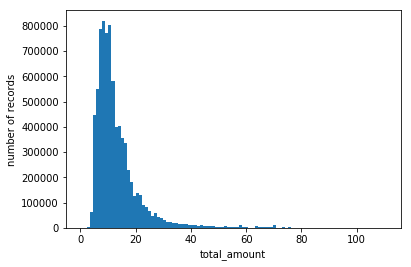

In [11]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

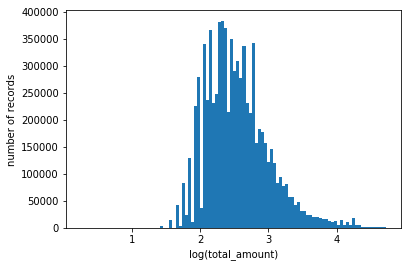

In [12]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

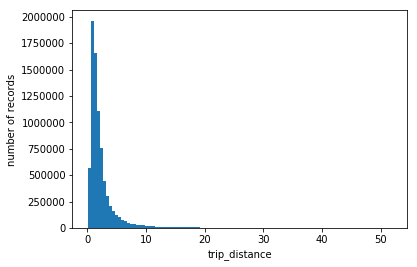

In [13]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

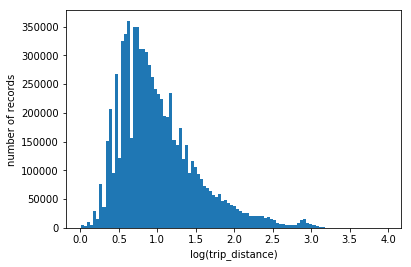

In [14]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

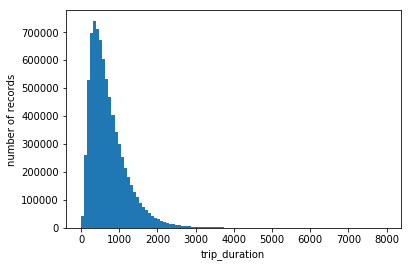

In [15]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

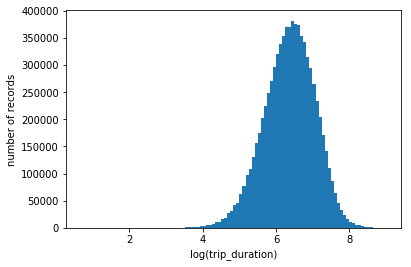

In [16]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

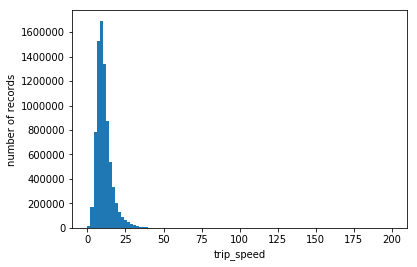

In [17]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

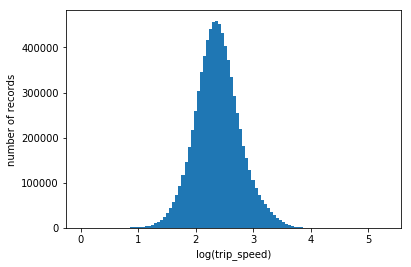

In [18]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

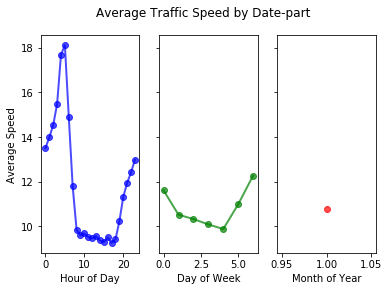

In [19]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(sample_manhattan.groupby('tpep_pickup_hour').mean()['trip_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(sample_manhattan.groupby('tpep_pickup_weekday').mean()['trip_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(sample_manhattan.groupby('tpep_pickup_month').mean()['trip_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

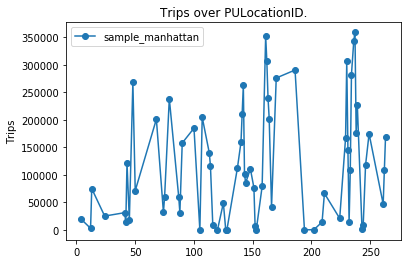

In [20]:
plt.plot(sample_manhattan.groupby(['PULocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over PULocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

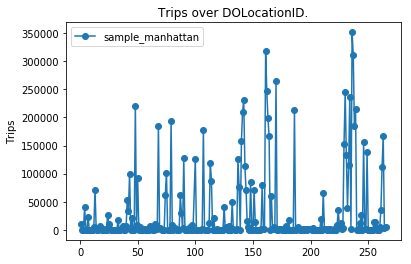

In [21]:
plt.plot(sample_manhattan.groupby(['DOLocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over DOLocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

In [22]:
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
#taxi_zones_shape['color'] = 'green'
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


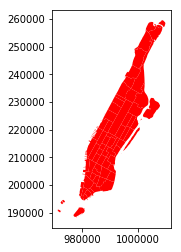

In [23]:
taxi_zones_shape.plot(color='red')

In [24]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
PULocationID_group.head()

,VendorID
PULocationID,
4,0.246
12,0.037
13,0.949
24,0.318
41,0.396


In [25]:
taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",0.246
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",0.037
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",0.949
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",0.318
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",0.396


taxi_zones_shape_requests: <class 'geopandas.geodataframe.GeoDataFrame'>


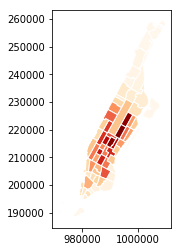

In [26]:
print('taxi_zones_shape_requests:', type(taxi_zones_shape_requests))
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

In [27]:
#for group_name, group_data in sample_manhattan.groupby(['tpep_pickup_5min_id']):
#    #print('group_name:', group_name)
#    #print(group_data.head())
#    PULocationID_group = group_data.groupby(['PULocationID']).count()[['VendorID']]
#    PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
#    #PULocationID_group.head()
#    taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
#    taxi_zones_shape_requests.fillna(0, inplace=True)
#    #taxi_zones_shape_requests.head()
#    #print('taxi_zones_shape_requests:', type(taxi_zones_shape_requests))
#    fig = taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')
#    fig.get_figure().savefig('images/'+str(group_name)+'.png')

In [28]:
train_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] < train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('train_sample_5min_count:', train_sample_5min_count.shape)
valid_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] >= train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('valid_sample_5min_count:', valid_sample_5min_count.shape)

train_sample_5min_count: (430343,)
valid_sample_5min_count: (45501,)


In [29]:
train_sample_5min_count.head()

tpep_pickup_5min_id  PULocationID
0.000                4               3
                     13              4
                     24              2
                     41              3
                     42              3
Name: VendorID, dtype: int64

In [30]:
valid_sample_5min_count.head()

tpep_pickup_5min_id  PULocationID
8064.000             4               2
                     12              1
                     13              1
                     24              1
                     41              1
Name: VendorID, dtype: int64

In [42]:
sample_manhattan_5min_pickup_count = sample_manhattan.groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
sample_manhattan_5min_dropoff_count = sample_manhattan.groupby(['tpep_pickup_5min_id', 'DOLocationID']).count()['VendorID']

In [43]:
def generate_features(data_X):
    start = time.time()
    ago_5min = []
    ago_5min_drop = []
    ago_1day_now = []
    ago_7day_now = []
    ago_14day_now = []
    ago_21day_now = []
    ago_28day_now = []
    for index,row in data_X.iterrows():
        #print('index:', index)
        #print('row:', row)
        try:
            ago_5min.append(sample_manhattan_5min_pickup_count[index[0]-1][index[1]])
        except:
            ago_5min.append(0)
        try:
            ago_5min_drop.append(sample_manhattan_5min_dropoff_count[index[0]-1][index[1]])
        except:
            ago_5min_drop.append(0)
        try:
            ago_1day_now.append(sample_manhattan_5min_pickup_count[index[0]-288][index[1]])
        except:
            ago_1day_now.append(0)
        try:
            ago_7day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*7][index[1]])
        except:
            ago_7day_now.append(0)
        try:
            ago_14day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*14][index[1]])
        except:
            ago_14day_now.append(0)
        try:
            ago_21day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*21][index[1]])
        except:
            ago_21day_now.append(0)
        try:
            ago_28day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*28][index[1]])
        except:
            ago_28day_now.append(0)
    data_X['5min_ago'] = np.array(ago_5min)
    data_X['5min_ago_drop'] = np.array(ago_5min_drop)
    data_X['1day_ago_now'] = np.array(ago_1day_now)
    data_X['7day_ago_now'] = np.array(ago_7day_now)
    data_X['14day_ago_now'] = np.array(ago_14day_now)
    data_X['21day_ago_now'] = np.array(ago_21day_now)
    data_X['28day_ago_now'] = np.array(ago_28day_now)
    print('data_X time:', time.time()-start)
    return data_X

In [44]:
train_X = pd.DataFrame(train_sample_5min_count)
print(train_X.index.shape)
train_X = generate_features(train_X)
print('train_X:', train_X.shape)
valid_X = pd.DataFrame(valid_sample_5min_count)
valid_X = generate_features(valid_X)
print('valid_X:', valid_X.shape)
train_Y = train_sample_5min_count.values
print('train_Y:', len(train_Y))
valid_Y = valid_sample_5min_count.values
print('valid_Y:', len(valid_Y))

(430343,)
data_X time: 872.2460784912109
train_X: (430343, 8)
data_X time: 125.92968535423279
valid_X: (45501, 8)
train_Y: 430343
valid_Y: 45501


In [45]:
train_X.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
0.000               4                    3         0              0   
                    13                   4         0              0   
                    24                   2         0              0   
                    41                   3         0              0   
                    42                   3         0              0   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
0.000               4                        0             0              0   
                    13                       0             0              0   
                    24                       0             0              0   
                    41                       0             0              0   
                    42                       0             0              0   

                                  21day_ago_now  28day_ago_now  
tpep_pickup_5min_id PULocationID                                
0.000               4                         0              0  
                    13                        0              0  
                    24                        0              0  
                    41                        0              0  
                    42                        0              0

In [46]:
train_X.describe()

,VendorID,5min_ago,5min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,430343.000,430343.000,430343.000,430343.000,430343.000,430343.000,430343.000,430343.000
mean,16.505,16.397,15.174,15.801,11.957,7.682,3.359,0.000
std,17.274,17.369,15.284,17.410,16.248,13.921,9.356,0.000
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3.000,3.000,4.000,3.000,0.000,0.000,0.000,0.000
50%,10.000,10.000,10.000,10.000,5.000,0.000,0.000,0.000
75%,24.000,24.000,22.000,24.000,18.000,10.000,0.000,0.000
max,173.000,173.000,161.000,157.000,157.000,150.000,128.000,0.000


In [47]:
valid_X.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
8064.000            4                    2         1              4   
                    12                   1         0              0   
                    13                   1         1              4   
                    24                   1         0              2   
                    41                   1         1              2   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
8064.000            4                       10             0              4   
                    12                       0             1              0   
                    13                       2             1              3   
                    24                       1             1              3   
                    41                       3             0              6   

                                  21day_ago_now  28day_ago_now  
tpep_pickup_5min_id PULocationID                                
8064.000            4                         1              3  
                    12                        0              0  
                    13                        2              4  
                    24                        2              2  
                    41                        1              3

In [48]:
valid_X.describe()

,VendorID,5min_ago,5min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,45501.000,45501.000,45501.000,45501.000,45501.000,45501.000,45501.000,45501.000
mean,17.770,17.658,16.402,16.292,17.192,16.676,16.319,14.069
std,18.878,18.972,16.906,17.468,18.606,17.825,17.289,15.069
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,3.000,4.000,3.000,3.000,3.000,3.000,3.000
50%,11.000,11.000,11.000,11.000,11.000,10.000,10.000,9.000
75%,26.000,26.000,24.000,24.000,25.000,25.000,24.000,21.000
max,135.000,135.000,156.000,173.000,148.000,137.000,129.000,128.000


In [62]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('VendorID', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('VendorID', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    # param['eta'] = 0.02
    param['max_depth'] = 20  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    # num_round = 5
    num_round = 400

    # param['objective'] = 'reg:linear'
    param['objective'] = 'reg:gamma'
    bst = xgb.train(param, xg_train, num_round, watchlist)

    # xgb.plot_tree(bst)
    # plt.savefig('xgboost_tree.png')
    # xgb.plot_importance(bst)
    # plt.savefig('xgboost_importance.png')
    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [50]:
pred = xgb_train_validate(train_X, train_Y, valid_X, valid_Y)

[0]	train-mae:15.9566	test-mae:17.2218
[1]	train-mae:15.9046	test-mae:17.1696
[2]	train-mae:15.8481	test-mae:17.1129
[3]	train-mae:15.7868	test-mae:17.0514
[4]	train-mae:15.7199	test-mae:16.9844
[5]	train-mae:15.648	test-mae:16.9121
[6]	train-mae:15.5696	test-mae:16.8336
[7]	train-mae:15.4859	test-mae:16.7493
[8]	train-mae:15.3973	test-mae:16.6599
[9]	train-mae:15.3049	test-mae:16.5666
[10]	train-mae:15.2077	test-mae:16.4685
[11]	train-mae:15.1054	test-mae:16.3648
[12]	train-mae:14.996	test-mae:16.2539
[13]	train-mae:14.8789	test-mae:16.1352
[14]	train-mae:14.7531	test-mae:16.0074
[15]	train-mae:14.6181	test-mae:15.8706
[16]	train-mae:14.4741	test-mae:15.7242
[17]	train-mae:14.321	test-mae:15.5685
[18]	train-mae:14.1586	test-mae:15.4024
[19]	train-mae:13.9865	test-mae:15.2258
[20]	train-mae:13.8039	test-mae:15.0384
[21]	train-mae:13.6114	test-mae:14.8402
[22]	train-mae:13.408	test-mae:14.6311
[23]	train-mae:13.1946	test-mae:14.4105
[24]	train-mae:12.9704	test-mae:14.1787
[25]	train-mae

[204]	train-mae:3.38391	test-mae:3.49553
[205]	train-mae:3.38339	test-mae:3.49575
[206]	train-mae:3.38317	test-mae:3.49566
[207]	train-mae:3.38309	test-mae:3.49572
[208]	train-mae:3.38302	test-mae:3.4957
[209]	train-mae:3.38278	test-mae:3.49568
[210]	train-mae:3.38268	test-mae:3.49572
[211]	train-mae:3.38244	test-mae:3.49581
[212]	train-mae:3.38225	test-mae:3.49559
[213]	train-mae:3.38219	test-mae:3.49562
[214]	train-mae:3.38219	test-mae:3.49561
[215]	train-mae:3.38211	test-mae:3.49562
[216]	train-mae:3.38211	test-mae:3.49565
[217]	train-mae:3.38196	test-mae:3.49592
[218]	train-mae:3.3819	test-mae:3.49594
[219]	train-mae:3.38184	test-mae:3.49594
[220]	train-mae:3.38181	test-mae:3.49595
[221]	train-mae:3.38165	test-mae:3.49596
[222]	train-mae:3.38165	test-mae:3.49596
[223]	train-mae:3.38163	test-mae:3.49595
[224]	train-mae:3.38157	test-mae:3.49597
[225]	train-mae:3.38137	test-mae:3.49631
[226]	train-mae:3.38115	test-mae:3.49682
[227]	train-mae:3.38095	test-mae:3.49674
[228]	train-mae:3.

In [55]:
train_sample_5min_mean = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] < train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).mean()
train_sample_5min_mean.drop(['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'DOLocationID', 'payment_type', 'tpep_pickup_15min_id', 'tpep_pickup_30min_id'], axis=1, inplace=True)
print('train_sample_5min_mean:', train_sample_5min_mean.shape)
valid_sample_5min_mean = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] >= train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).mean()
valid_sample_5min_mean.drop(['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'DOLocationID', 'payment_type', 'tpep_pickup_15min_id', 'tpep_pickup_30min_id'], axis=1, inplace=True)
print('valid_sample_5min_mean:', train_sample_5min_mean.shape)

train_sample_5min_mean: (430343, 23)
valid_sample_5min_mean: (430343, 23)


In [56]:
train_sample_5min_mean.head()

passenger_count  trip_distance  fare_amount  \
tpep_pickup_5min_id PULocationID                                                
0.000               4                       1.667          1.203        7.500   
                    13                      1.000          2.435       10.125   
                    24                      1.500          2.775       11.500   
                    41                      1.333          1.317        7.000   
                    42                      1.667          4.920       19.333   

                                  extra  mta_tax  tip_amount  tolls_amount  \
tpep_pickup_5min_id PULocationID                                             
0.000               4             0.500    0.500       0.817         0.000   
                    13            0.500    0.500       0.580         0.000   
                    24            0.500    0.500       0.000         0.000   
                    41            0.500    0.500       0.567         0.000   
                    42            0.500    0.500       0.000         0.000   

                                  improvement_surcharge  total_amount  \
tpep_pickup_5min_id PULocationID                                        
0.000               4                             0.300         9.617   
                    13                            0.300        12.005   
                    24                            0.300        12.800   
                    41                            0.300         8.867   
                    42                            0.300        20.633   

                                  trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id PULocationID                                                
0.000               4                   501.000       9.918          2018.000   
                    13                  524.500      15.570          2018.000   
                    24                  709.500      13.941          2018.000   
                    41                  376.333      12.232          2018.000   
                    42                 1317.000      14.847          2018.000   

                                  tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id PULocationID                                       
0.000               4                         1.000            1.000   
                    13                        1.000            1.000   
                    24                        1.000            1.000   
                    41                        1.000            1.000   
                    42                        1.000            1.000   

                                  tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id PULocationID                                          
0.000               4                        0.000                0.000   
                    13                       0.000                0.000   
                    24                       0.000                0.000   
                    41                       0.000                0.000   
                    42                       0.000                0.000   

                                  is_weekend  is_morning_peak  \
tpep_pickup_5min_id PULocationID                                
0.000               4                  0.000            0.000   
                    13                 0.000            0.000   
                    24                 0.000            0.000   
                    41                 0.000            0.000   
                    42                 0.000            0.000   

                                  is_evening_peak  log_total_amount  \
tpep_pickup_5min_id PULocationID                                      
0.000               4                       0.000             2.293   
                    13                      0.000             2.460   
                    24                      0.000             2.614 

In [57]:
valid_sample_5min_mean.head()

passenger_count  trip_distance  fare_amount  \
tpep_pickup_5min_id PULocationID                                                
8064.000            4                       1.000          2.035        9.000   
                    12                      1.000          7.000       22.500   
                    13                      1.000          2.200        8.500   
                    24                      1.000          1.010        5.000   
                    41                      1.000          3.950       14.000   

                                  extra  mta_tax  tip_amount  tolls_amount  \
tpep_pickup_5min_id PULocationID                                             
8064.000            4             0.500    0.500       0.750         0.000   
                    12            0.500    0.500       5.950         0.000   
                    13            0.500    0.500       1.950         0.000   
                    24            0.500    0.500       1.260         0.000   
                    41            0.500    0.500       0.000         0.000   

                                  improvement_surcharge  total_amount  \
tpep_pickup_5min_id PULocationID                                        
8064.000            4                             0.300        11.050   
                    12                            0.300        29.750   
                    13                            0.300        11.750   
                    24                            0.300         7.560   
                    41                            0.300        15.300   

                                  trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id PULocationID                                                
8064.000            4                   518.000      13.642          2018.000   
                    12                 1074.000      23.464          2018.000   
                    13                  382.000      20.733          2018.000   
                    24                  181.000      20.088          2018.000   
                    41                  905.000      15.713          2018.000   

                                  tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id PULocationID                                       
8064.000            4                         1.000           29.000   
                    12                        1.000           29.000   
                    13                        1.000           29.000   
                    24                        1.000           29.000   
                    41                        1.000           29.000   

                                  tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id PULocationID                                          
8064.000            4                        0.000                0.000   
                    12                       0.000                0.000   
                    13                       0.000                0.000   
                    24                       0.000                0.000   
                    41                       0.000                0.000   

                                  is_weekend  is_morning_peak  \
tpep_pickup_5min_id PULocationID                                
8064.000            4                  0.000            0.000   
                    12                 0.000            0.000   
                    13                 0.000            0.000   
                    24                 0.000            0.000   
                    41                 0.000            0.000   

                                  is_evening_peak  log_total_amount  \
tpep_pickup_5min_id PULocationID                                      
8064.000            4                       0.000             2.438   
                    12                      0.000             3.426   
                    13                      0.000             2.546 

In [64]:
train_sample_5min_mean_static = pd.DataFrame(train_sample_5min_mean, columns=['tpep_pickup_year', 'tpep_pickup_month', 'tpep_pickup_day', 'tpep_pickup_hour', 'tpep_pickup_weekday', 'is_weekend', 'is_morning_peak', 'is_evening_peak'])
valid_sample_5min_mean_static = pd.DataFrame(valid_sample_5min_mean, columns=['tpep_pickup_year', 'tpep_pickup_month', 'tpep_pickup_day', 'tpep_pickup_hour', 'tpep_pickup_weekday', 'is_weekend', 'is_morning_peak', 'is_evening_peak'])

In [65]:
train_sample_5min_mean_static.head()

tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
0.000               4                     2018.000              1.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   
                    42                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
0.000               4                       1.000             0.000   
                    13                      1.000             0.000   
                    24                      1.000             0.000   
                    41                      1.000             0.000   
                    42                      1.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
0.000               4                           0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   
                    42                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
0.000               4                       0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000  
                    42                      0.000            0.000

In [66]:
valid_sample_5min_mean_static.head()

tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
8064.000            4                     2018.000              1.000   
                    12                    2018.000              1.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
8064.000            4                      29.000             0.000   
                    12                     29.000             0.000   
                    13                     29.000             0.000   
                    24                     29.000             0.000   
                    41                     29.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
8064.000            4                           0.000       0.000   
                    12                          0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
8064.000            4                       0.000            0.000  
                    12                      0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000

In [67]:
train_X_new = train_X.join(train_sample_5min_mean_static)
print('train_X_new:', train_X_new.shape)
valid_X_new = valid_X.join(valid_sample_5min_mean_static)
print('valid_X_new:', valid_X_new.shape)

train_X_new: (430343, 16)
valid_X_new: (45501, 16)


In [68]:
train_X_new.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
0.000               4                    3         0              0   
                    13                   4         0              0   
                    24                   2         0              0   
                    41                   3         0              0   
                    42                   3         0              0   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
0.000               4                        0             0              0   
                    13                       0             0              0   
                    24                       0             0              0   
                    41                       0             0              0   
                    42                       0             0              0   

                                  21day_ago_now  28day_ago_now  \
tpep_pickup_5min_id PULocationID                                 
0.000               4                         0              0   
                    13                        0              0   
                    24                        0              0   
                    41                        0              0   
                    42                        0              0   

                                  tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
0.000               4                     2018.000              1.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   
                    42                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
0.000               4                       1.000             0.000   
                    13                      1.000             0.000   
                    24                      1.000             0.000   
                    41                      1.000             0.000   
                    42                      1.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
0.000               4                           0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   
                    42                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
0.000               4                       0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000  
                    42                      0.000            0.000

In [69]:
valid_X_new.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
8064.000            4                    2         1              4   
                    12                   1         0              0   
                    13                   1         1              4   
                    24                   1         0              2   
                    41                   1         1              2   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
8064.000            4                       10             0              4   
                    12                       0             1              0   
                    13                       2             1              3   
                    24                       1             1              3   
                    41                       3             0              6   

                                  21day_ago_now  28day_ago_now  \
tpep_pickup_5min_id PULocationID                                 
8064.000            4                         1              3   
                    12                        0              0   
                    13                        2              4   
                    24                        2              2   
                    41                        1              3   

                                  tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
8064.000            4                     2018.000              1.000   
                    12                    2018.000              1.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
8064.000            4                      29.000             0.000   
                    12                     29.000             0.000   
                    13                     29.000             0.000   
                    24                     29.000             0.000   
                    41                     29.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
8064.000            4                           0.000       0.000   
                    12                          0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
8064.000            4                       0.000            0.000  
                    12                      0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000

In [71]:
pred_new = xgb_train_validate(train_X_new, train_Y, valid_X_new, valid_Y)

[0]	train-mae:15.957	test-mae:17.2221
[1]	train-mae:15.9051	test-mae:17.1701
[2]	train-mae:15.8487	test-mae:17.1136
[3]	train-mae:15.7875	test-mae:17.0522
[4]	train-mae:15.7212	test-mae:16.9858
[5]	train-mae:15.6495	test-mae:16.914
[6]	train-mae:15.572	test-mae:16.8364
[7]	train-mae:15.488	test-mae:16.7528
[8]	train-mae:15.3995	test-mae:16.6641
[9]	train-mae:15.3068	test-mae:16.5708
[10]	train-mae:15.2093	test-mae:16.4725
[11]	train-mae:15.1059	test-mae:16.3677
[12]	train-mae:14.9954	test-mae:16.2563
[13]	train-mae:14.8773	test-mae:16.1376
[14]	train-mae:14.7504	test-mae:16.0101
[15]	train-mae:14.6148	test-mae:15.8734
[16]	train-mae:14.4698	test-mae:15.7279
[17]	train-mae:14.3159	test-mae:15.5718
[18]	train-mae:14.1523	test-mae:15.4075
[19]	train-mae:13.9786	test-mae:15.2318
[20]	train-mae:13.7947	test-mae:15.0454
[21]	train-mae:13.6001	test-mae:14.848
[22]	train-mae:13.3951	test-mae:14.64
[23]	train-mae:13.1789	test-mae:14.4206
[24]	train-mae:12.9521	test-mae:14.189
[25]	train-mae:12.

[204]	train-mae:3.12401	test-mae:3.47909
[205]	train-mae:3.12382	test-mae:3.47909
[206]	train-mae:3.12312	test-mae:3.47924
[207]	train-mae:3.12264	test-mae:3.47954
[208]	train-mae:3.12229	test-mae:3.4797
[209]	train-mae:3.12188	test-mae:3.47972
[210]	train-mae:3.12115	test-mae:3.47967
[211]	train-mae:3.12116	test-mae:3.47966
[212]	train-mae:3.12077	test-mae:3.47954
[213]	train-mae:3.12053	test-mae:3.47959
[214]	train-mae:3.11984	test-mae:3.48139
[215]	train-mae:3.11917	test-mae:3.48175
[216]	train-mae:3.11891	test-mae:3.48172
[217]	train-mae:3.11873	test-mae:3.48215
[218]	train-mae:3.1184	test-mae:3.48227
[219]	train-mae:3.11816	test-mae:3.48248
[220]	train-mae:3.11805	test-mae:3.48249
[221]	train-mae:3.11743	test-mae:3.48278
[222]	train-mae:3.11673	test-mae:3.48286
[223]	train-mae:3.11632	test-mae:3.48293
[224]	train-mae:3.11632	test-mae:3.48293
[225]	train-mae:3.11575	test-mae:3.48373
[226]	train-mae:3.11549	test-mae:3.48347
[227]	train-mae:3.11522	test-mae:3.48357
[228]	train-mae:3.

In [72]:
pred_new

array([2.5260484, 1.2202721, 1.8776902, ..., 6.1029243, 1.568884 ,
       4.2590055], dtype=float32)

In [79]:
valid_pred = pd.DataFrame(valid_X, columns=['VendorID'])
valid_pred.reset_index(inplace=True)
valid_pred['pred'] = pred_new

In [80]:
valid_pred.head()

,tpep_pickup_5min_id,PULocationID,VendorID,pred
0,8064.000,4,2,2.526
1,8064.000,12,1,1.220
2,8064.000,13,1,1.878
3,8064.000,24,1,1.400
4,8064.000,41,1,1.955


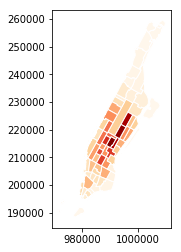

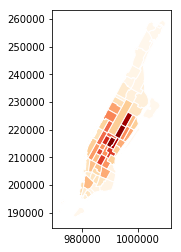

In [81]:
valid_pred_group = valid_pred.groupby(['PULocationID']).sum()[['VendorID', 'pred']]
taxi_zones_shape_requests_pred = taxi_zones_shape.join(valid_pred_group, on=['LocationID'], how='left')
taxi_zones_shape_requests_pred.fillna(0, inplace=True)
taxi_zones_shape_requests_pred.plot(column='VendorID', cmap='OrRd', edgecolor='white')
taxi_zones_shape_requests_pred.plot(column='pred', cmap='OrRd', edgecolor='white')

In [82]:
valid_pred_group

,VendorID,pred
PULocationID,,
4,1364,1275.009
12,220,224.847
13,9122,8283.579
24,2423,2069.097
41,2557,2430.687
42,1149,1094.458
43,12090,11632.244
45,1621,1394.048
48,24855,24579.646


In [83]:
train_X_new.to_csv('train_X_new.csv', index=True)
valid_X_new.to_csv('valid_X_new.csv', index=True)

In [115]:
train_X_all_tpep_pickup_5min_id = np.array([i for i in range(int(train_valid_split_5min_id)) for _ in range(len(manhattan_location_ids))])
train_X_all_PULocationID = np.array([i for _ in range(int(train_valid_split_5min_id)) for i in manhattan_location_ids])
valid_X_all_tpep_pickup_5min_id = np.array([i for i in range(int(train_valid_split_5min_id), int(last_5min_id)) for _ in range(len(manhattan_location_ids))])
valid_X_all_PULocationID = np.array([i for _ in range(int(train_valid_split_5min_id), int(last_5min_id)) for i in manhattan_location_ids])
print('manhattan_location_ids_array:', manhattan_location_ids_array.shape, manhattan_location_ids_array)
print('train_X_all_tpep_pickup_5min_id:', train_X_all_tpep_pickup_5min_id.shape, train_X_all_tpep_pickup_5min_id)
print('train_X_all_PULocationID:', train_X_all_PULocationID.shape, train_X_all_PULocationID)
print('valid_X_all_tpep_pickup_5min_id:', valid_X_all_tpep_pickup_5min_id.shape, valid_X_all_tpep_pickup_5min_id)
print('valid_X_all_PULocationID:', valid_X_all_PULocationID.shape, valid_X_all_PULocationID)

manhattan_location_ids_array: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
train_X_all_tpep_pickup_5min_id: (556416,) [   0    0    0 ... 8063 8063 8063]
train_X_all_PULocationID: (556416,) [  4  12  13 ... 261 262 263]
valid_X_all_tpep_pickup_5min_id: (59616,) [8064 8064 8064 ... 8927 8927 8927]
valid_X_all_PULocationID: (59616,) [  4  12  13 ... 261 262 263]


In [131]:
train_X_all = pd.DataFrame({'tpep_pickup_5min_id': train_X_all_tpep_pickup_5min_id, 'PULocationID': train_X_all_PULocationID})
train_X_all.set_index(['tpep_pickup_5min_id', 'PULocationID'], inplace=True)
print('train_X_all:', train_X_all.shape)
valid_X_all = pd.DataFrame({'tpep_pickup_5min_id': valid_X_all_tpep_pickup_5min_id, 'PULocationID': valid_X_all_PULocationID})
valid_X_all.set_index(['tpep_pickup_5min_id', 'PULocationID'], inplace=True)
print('valid_X_all:', valid_X_all.shape)

train_X_all: (556416, 0)
valid_X_all: (59616, 0)


In [132]:
train_X_all.head()

Empty DataFrame
Columns: []
Index: [(0, 4), (0, 12), (0, 13), (0, 24), (0, 41)]

In [133]:
valid_X_all.head()

Empty DataFrame
Columns: []
Index: [(8064, 4), (8064, 12), (8064, 13), (8064, 24), (8064, 41)]

In [134]:
train_X_all = train_X_all.join(train_X_new, how='left')
print('train_X_all:', train_X_all.shape)
valid_X_all = valid_X_all.join(valid_X_new, how='left')
print('valid_X_all:', valid_X_all.shape)

train_X_all: (556416, 16)
valid_X_all: (59616, 16)


In [135]:
train_X_all.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
0                   4                3.000     0.000          0.000   
                    12                 nan       nan            nan   
                    13               4.000     0.000          0.000   
                    24               2.000     0.000          0.000   
                    41               3.000     0.000          0.000   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
0                   4                    0.000         0.000          0.000   
                    12                     nan           nan            nan   
                    13                   0.000         0.000          0.000   
                    24                   0.000         0.000          0.000   
                    41                   0.000         0.000          0.000   

                                  21day_ago_now  28day_ago_now  \
tpep_pickup_5min_id PULocationID                                 
0                   4                     0.000          0.000   
                    12                      nan            nan   
                    13                    0.000          0.000   
                    24                    0.000          0.000   
                    41                    0.000          0.000   

                                  tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
0                   4                     2018.000              1.000   
                    12                         nan                nan   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
0                   4                       1.000             0.000   
                    12                        nan               nan   
                    13                      1.000             0.000   
                    24                      1.000             0.000   
                    41                      1.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
0                   4                           0.000       0.000   
                    12                            nan         nan   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
0                   4                       0.000            0.000  
                    12                        nan              nan  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000

In [136]:
valid_X_all.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
8064                4                2.000     1.000          4.000   
                    12               1.000     0.000          0.000   
                    13               1.000     1.000          4.000   
                    24               1.000     0.000          2.000   
                    41               1.000     1.000          2.000   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
8064                4                   10.000         0.000          4.000   
                    12                   0.000         1.000          0.000   
                    13                   2.000         1.000          3.000   
                    24                   1.000         1.000          3.000   
                    41                   3.000         0.000          6.000   

                                  21day_ago_now  28day_ago_now  \
tpep_pickup_5min_id PULocationID                                 
8064                4                     1.000          3.000   
                    12                    0.000          0.000   
                    13                    2.000          4.000   
                    24                    2.000          2.000   
                    41                    1.000          3.000   

                                  tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
8064                4                     2018.000              1.000   
                    12                    2018.000              1.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
8064                4                      29.000             0.000   
                    12                     29.000             0.000   
                    13                     29.000             0.000   
                    24                     29.000             0.000   
                    41                     29.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
8064                4                           0.000       0.000   
                    12                          0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
8064                4                       0.000            0.000  
                    12                      0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000

In [138]:
train_X_all.fillna(0.0, inplace=True)
valid_X_all.fillna(0.0, inplace=True)

In [139]:
train_X_all.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
0                   4                3.000     0.000          0.000   
                    12               0.000     0.000          0.000   
                    13               4.000     0.000          0.000   
                    24               2.000     0.000          0.000   
                    41               3.000     0.000          0.000   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
0                   4                    0.000         0.000          0.000   
                    12                   0.000         0.000          0.000   
                    13                   0.000         0.000          0.000   
                    24                   0.000         0.000          0.000   
                    41                   0.000         0.000          0.000   

                                  21day_ago_now  28day_ago_now  \
tpep_pickup_5min_id PULocationID                                 
0                   4                     0.000          0.000   
                    12                    0.000          0.000   
                    13                    0.000          0.000   
                    24                    0.000          0.000   
                    41                    0.000          0.000   

                                  tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
0                   4                     2018.000              1.000   
                    12                       0.000              0.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
0                   4                       1.000             0.000   
                    12                      0.000             0.000   
                    13                      1.000             0.000   
                    24                      1.000             0.000   
                    41                      1.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
0                   4                           0.000       0.000   
                    12                          0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
0                   4                       0.000            0.000  
                    12                      0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000

In [140]:
valid_X_all.head()

VendorID  5min_ago  5min_ago_drop  \
tpep_pickup_5min_id PULocationID                                      
8064                4                2.000     1.000          4.000   
                    12               1.000     0.000          0.000   
                    13               1.000     1.000          4.000   
                    24               1.000     0.000          2.000   
                    41               1.000     1.000          2.000   

                                  1day_ago_now  7day_ago_now  14day_ago_now  \
tpep_pickup_5min_id PULocationID                                              
8064                4                   10.000         0.000          4.000   
                    12                   0.000         1.000          0.000   
                    13                   2.000         1.000          3.000   
                    24                   1.000         1.000          3.000   
                    41                   3.000         0.000          6.000   

                                  21day_ago_now  28day_ago_now  \
tpep_pickup_5min_id PULocationID                                 
8064                4                     1.000          3.000   
                    12                    0.000          0.000   
                    13                    2.000          4.000   
                    24                    2.000          2.000   
                    41                    1.000          3.000   

                                  tpep_pickup_year  tpep_pickup_month  \
tpep_pickup_5min_id PULocationID                                        
8064                4                     2018.000              1.000   
                    12                    2018.000              1.000   
                    13                    2018.000              1.000   
                    24                    2018.000              1.000   
                    41                    2018.000              1.000   

                                  tpep_pickup_day  tpep_pickup_hour  \
tpep_pickup_5min_id PULocationID                                      
8064                4                      29.000             0.000   
                    12                     29.000             0.000   
                    13                     29.000             0.000   
                    24                     29.000             0.000   
                    41                     29.000             0.000   

                                  tpep_pickup_weekday  is_weekend  \
tpep_pickup_5min_id PULocationID                                    
8064                4                           0.000       0.000   
                    12                          0.000       0.000   
                    13                          0.000       0.000   
                    24                          0.000       0.000   
                    41                          0.000       0.000   

                                  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id PULocationID                                    
8064                4                       0.000            0.000  
                    12                      0.000            0.000  
                    13                      0.000            0.000  
                    24                      0.000            0.000  
                    41                      0.000            0.000

In [144]:
train_Y_all = train_X_all['VendorID'].values
valid_Y_all = valid_X_all['VendorID'].values

In [ ]:
pred_all = xgb_train_validate(train_X_all, train_Y_all, valid_X_all, valid_Y_all)

[0]	train-mae:12.3415	test-mae:13.1445
[1]	train-mae:12.3012	test-mae:13.1047
[2]	train-mae:12.2573	test-mae:13.0617
[3]	train-mae:12.21	test-mae:13.0149
[4]	train-mae:12.1587	test-mae:12.9642
[5]	train-mae:12.1029	test-mae:12.9092
[6]	train-mae:12.0429	test-mae:12.8497
[7]	train-mae:11.9783	test-mae:12.7858
[8]	train-mae:11.9099	test-mae:12.7182
[9]	train-mae:11.8381	test-mae:12.6469
[10]	train-mae:11.7628	test-mae:12.572
[11]	train-mae:11.683	test-mae:12.4925
[12]	train-mae:11.5977	test-mae:12.4077
[13]	train-mae:11.5064	test-mae:12.3169
[14]	train-mae:11.4083	test-mae:12.2193
[15]	train-mae:11.3032	test-mae:12.1151
[16]	train-mae:11.1912	test-mae:12.0037
[17]	train-mae:11.0722	test-mae:11.8853
[18]	train-mae:10.9458	test-mae:11.7593
[19]	train-mae:10.8113	test-mae:11.6253
[20]	train-mae:10.6692	test-mae:11.4826
[21]	train-mae:10.5187	test-mae:11.3318
[22]	train-mae:10.36	test-mae:11.1727
[23]	train-mae:10.193	test-mae:11.0053
[24]	train-mae:10.0178	test-mae:10.8291
[25]	train-mae:9.

[204]	train-mae:2.42228	test-mae:2.66252
[205]	train-mae:2.42138	test-mae:2.66202
[206]	train-mae:2.42106	test-mae:2.6622
[207]	train-mae:2.42097	test-mae:2.66245
[208]	train-mae:2.42082	test-mae:2.66261
[209]	train-mae:2.42046	test-mae:2.66314
[210]	train-mae:2.41945	test-mae:2.66362
[211]	train-mae:2.41918	test-mae:2.66378
[212]	train-mae:2.41916	test-mae:2.66379
[213]	train-mae:2.41863	test-mae:2.66474
[214]	train-mae:2.41839	test-mae:2.66489
[215]	train-mae:2.41832	test-mae:2.66494
[216]	train-mae:2.418	test-mae:2.66501
[217]	train-mae:2.41795	test-mae:2.66509
[218]	train-mae:2.41776	test-mae:2.66517
[219]	train-mae:2.41776	test-mae:2.66518
[220]	train-mae:2.41745	test-mae:2.66515
[221]	train-mae:2.41727	test-mae:2.66524
[222]	train-mae:2.41699	test-mae:2.66524
[223]	train-mae:2.4167	test-mae:2.66523
[224]	train-mae:2.41666	test-mae:2.66523
[225]	train-mae:2.41667	test-mae:2.66524
[226]	train-mae:2.41627	test-mae:2.66535
[227]	train-mae:2.41587	test-mae:2.66517
[228]	train-mae:2.41